# Computer Vision 2: CNNs

This notebook is based on fastai's **[Chapter 13](https://github.com/fastai/fastbook/blob/master/13_convolutions.ipynb)**.

Please read this chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.all import *
from fastai.callback.hook import *

matplotlib.rc('image', cmap='Greys')

# Data

### Download 3s vs 7s

In [4]:
# path
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [5]:
# get dataloaders
mnist = DataBlock(
  (ImageBlock(cls=PILImageBW), CategoryBlock),
  get_items=get_image_files,
  splitter=GrandparentSplitter(),
  get_y=parent_label
)

dls = mnist.dataloaders(path)

# dls has size: 64 x 1 x 28 x 28
  # 64 images in a batch
  # 1 channel (black and white)
  # 28 pixels high
  # 28 pixels wide

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [6]:
# get mini-batch
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [7]:
# since we're using small data here, move to cpu
xb,yb = to_cpu(xb),to_cpu(yb)

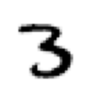

In [8]:
# example
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

### Download all MNIST

In [9]:
# path
complete_path = untar_data(URLs.MNIST)
Path.BASE_PATH = complete_path
print(complete_path.ls())

[Path('training'), Path('testing')]


In [10]:
# dataloaders
def get_mnist_dls(bs=64):
  return DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter('training','testing'),
    get_y=parent_label,
    batch_tfms=Normalize()
  ).dataloaders(complete_path, bs=bs)

mnist_dls = get_mnist_dls()

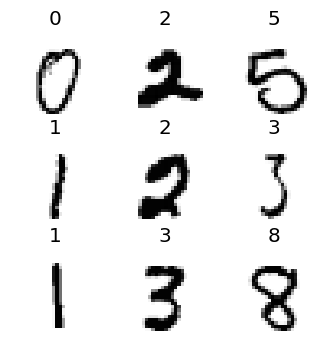

In [11]:
# example
mnist_dls.show_batch(max_n=9, figsize=(4,4))

### Side note: preprocessing color images
  - Do NOT change to black and white -- bad idea (loses information)
  - Could be a good idea to change from RGB to hue, saturation, and value

## Convolutions
- Convolutions help figure out where edges are in images
- Applies a *kernel* (matrix) across the pixels of an image
  - Say the kernel is a 3x3 matrix and the pixels of the image form a 7x7 matrix
  - A subset block (size 3x3) is taken
  - Each element of the subset is multiplied by the corresponding element in the kernel
  - The results are added together

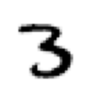

In [12]:
# get image
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [13]:
# get pixels of image
im3_t = tensor(im3)
print(im3_t.shape)

torch.Size([28, 28])


In [14]:
# show some of the pixels
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


#### Top Edge Detection

In [15]:
# create kernel
  # this essentially takes negatives of the values in the top row
  # ignores the middle row
  # takes positives of the bottom row
top_edge = tensor([
  [-1,-1,-1],
  [ 0, 0, 0],
  [ 1, 1, 1]
]).float()
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [16]:
# create function to apply kernel over 3x3 subset of image
def apply_kernel(row, col, kernel):
  return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

**Exploring this function part by part**

In [17]:
# array slicing: extracts a 3x3 sub-matrix from im3_t
row, col = 5, 7 # here, takes from row 4-6 and 6-8
sub = im3_t[row-1:row+2,col-1:col+2]
sub

tensor([[  0,   0,   0],
        [142, 155, 246],
        [254, 254, 254]], dtype=torch.uint8)

In [18]:
# element wise multiplication
# multiply the corresponding elements of each matrix (e.g., bottom left * bottom left, aka 1 * 254 = 254)
kernel = top_edge
res = sub * kernel

print(kernel)
print()
print(sub)
print()
print(res)

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

tensor([[  0,   0,   0],
        [142, 155, 246],
        [254, 254, 254]], dtype=torch.uint8)

tensor([[ -0.,  -0.,  -0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]])


In [19]:
# sum the results (add all the elements of the res matrix)
res.sum()

tensor(762.)

**What happens when the pixels of the image don't have a top edge?**

Top row and the sum of the bottom row cancel each other out, so you get 0, Therefore, it correctly says this is NOT a top edge.

In [20]:
# subset [0:2, 2:4]
apply_kernel(1,3,top_edge)

tensor(0.)

**What happens if they do have a top edge?**

Sum of bottom row is much bigger than sum of top row, so it correctly says this IS a top edge.

In [21]:
# same one we saw above! subset [4:6, 6:8]
apply_kernel(5,7,top_edge)

tensor(762.)

**What if they have the wrong kind of edge (right edge)?**

There's no pattern between top and bottom, so it gives weird numbers (here, negative). It correctly says this is not a top edge.

In [22]:
# subset [7:9,17:19]
apply_kernel(8,18,top_edge)

tensor(-29.)

**Apply across a grid of coordinates**

Note that this shows the top edges are black and the bottom edges are white (since they are the opposite of top edges)

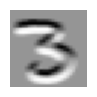

In [23]:
# iterate over rows (i), columns (j) in range 1:26
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])
show_image(top_edge3);

#### Left Edge Detection

In [24]:
# create kernel
left_edge = tensor([
  [-1,1,0],
  [-1,1,0],
  [-1,1,0]
]).float()

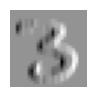

In [25]:
# apply across a coordinate grid
# can see it is dark where left edges are and white where right edges are
left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3);

### Using PyTorch

In [26]:
# create diagonal kernels
diag1_edge = tensor([
  [ 0,-1, 1],
  [-1, 1, 0],
  [ 1, 0, 0]
]).float()

diag2_edge = tensor([
  [ 1,-1, 0],
  [ 0, 1,-1],
  [ 0, 0, 1]
]).float()

In [27]:
# stack all 4 kernels (detecting top, bottom, diagonal edges) together
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])

print(edge_kernels.shape) # 4 kernels, each of which are 3x3
edge_kernels

torch.Size([4, 3, 3])


tensor([[[-1.,  1.,  0.],
         [-1.,  1.,  0.],
         [-1.,  1.,  0.]],

        [[-1., -1., -1.],
         [ 0.,  0.,  0.],
         [ 1.,  1.,  1.]],

        [[ 0., -1.,  1.],
         [-1.,  1.,  0.],
         [ 1.,  0.,  0.]],

        [[ 1., -1.,  0.],
         [ 0.,  1., -1.],
         [ 0.,  0.,  1.]]])

In [28]:
# PyTorch requires rank-4 tensors: [channels_in, features_out, rows, columns]
# add the missing channel: unsqueeze adds a new dimension of size 1 to a tensor
# by passing .unsqueeze() a 1, it means add the new dimension at position 1
edge_kernels = edge_kernels.unsqueeze(1)
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [29]:
# recall batch
# 64 images, each of 1 channel (black and white), with 28x28 pixels
xb.shape

torch.Size([64, 1, 28, 28])

In [30]:
# find edges
# 64 images, 4 kernels, 26x26 edge maps (lost one pixel from each side because they don't form a 3x3 grid)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

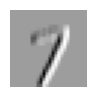

In [31]:
# show sample results
show_image(batch_features[0,0]);

**Side note about channels and features:**
- "These two terms are largely used interchangeably, and refer to the size of the second axis of a weight matrix, which is, the number of activations per grid cell after a convolution. Features is never used to refer to the input data, but channels can refer to either the input data (generally channels are colors) or activations inside the network"

### Aside: Color Images
- Color images are rank-3 tensors. They have multiple channels: e.g., one for red, green, blue colors
- The kernel needs to have a size that matches the first axis of the picture (the number of channels)
- Can have different filters (different parts of the kernel) for different channels
- Still multiply the elements of the channel window (the subset of image) by the filter, then add the results of all the filters (e.g., red + green + blue)
- Output has size channel out x channel in x kernel size x kernel size -- in other words, for each channel, size (channel in x kernel size x kernel size)
- Weights are also the size channel out x channel in x kernel size x kernel size
- Can also have biases

torch.Size([3, 1000, 846])


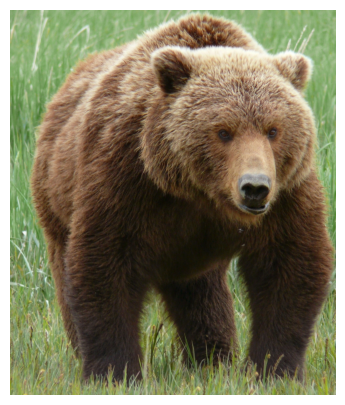

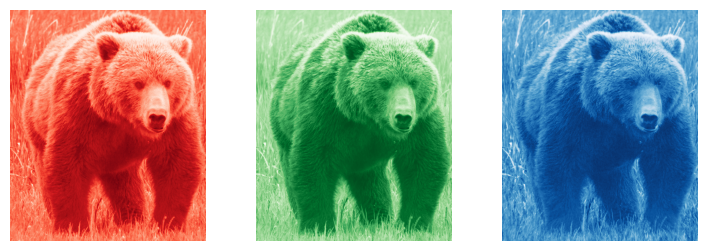

In [32]:
# original
im = image2tensor(Image.open(image_bear()))
show_image(im);

# first dimension has 3 channels: red, green, blue
print(im.shape)

# show channels
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
  show_image(255-bear, ax=ax, cmap=color)

# Baseline CNN Model
- Can learn the values of the kernels with SGD
- Can use convolutions instead of (or in addition to) linear layers

### Basics
This won't work (it is named `broken_cnn` to remind us of that), but is conceptually showing what a CNN does

In [33]:
# recall linear NN
simple_net = nn.Sequential(
  nn.Linear(28*28,30),
  nn.ReLU(),
  nn.Linear(30,1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [34]:
# convolutional NN
  # don/t need to specify input size: weights only depend on the number of input and output channels and the kernel size
  # padding: add extra pixels to ensure the output activation map is the same size as the original image
broken_cnn = sequential(
  nn.Conv2d(1,30, kernel_size=3, padding=1),
  nn.ReLU(),
  nn.Conv2d(30,1, kernel_size=3, padding=1)
)
print(broken_cnn)

# notice the output shape doesn't work for classification -- we need one output per image
broken_cnn(xb).shape

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


torch.Size([64, 1, 28, 28])

### Strides
- **Stride**: number of pixels to move over after each kernel application -- you skip pixels when applying the filter
- Moving over 2 pixels (skipping every other pixel) = stride-2 convolution
- This means the output will have less dimensions than the input. This is downsampling.
- We need enough stride-2 convolutions so the final layer is size 1. We are using strides to get the desired output

In [35]:
def conv(ni, nf, ks=3, act=True):
  """
  defines a 2D convolutional layer with an optional ReLU activation function
  """
  res = nn.Conv2d(
    ni, # number of input channels
    nf, # number of output channels
    stride=2, # stride 2 in both width and height directions
    kernel_size=ks, # kernel size
    padding=ks//2 # applies zero-padding to maintain the spatial dimensions of the input.
  )
  if act: res = nn.Sequential(res, nn.ReLU()) # optional activation function
  return res # either the convolutional layer alone or the layer + ReLU activation (depending on act)

In [36]:
# create a sequential NN model: each layer will be executed sequentially
# we need enough stride-2 convolutions so the final layer is size 1

# this assumes the input size is 28x28 pixels
simple_cnn = sequential(
  conv(1,4), # 1 input channel (black and white); 4 output channels (filters or feature maps); includes ReLU --> results in 14x14 pixel images because of stride 2
  conv(4,8), # 4 input channels (from previous layer); 8 output channels; includes ReLU --> results in 7x7 pixel images because of stride 2
  conv(8,16), # similar to above --> results in 4x4 pixel images because of stride 2
  conv(16,32), # results in 2x2 pixel images because of stride 2
  conv(32,2, act=False), # 32 input channels (from previous layer); 3 output channels (for 2 classification categories, 3 or 7); NO activation layer --> results in 1x1 pixel images which is suitable for a final classification layer
  Flatten(), # reshapes the output tensor into a 1D tensor (useful if passing to other layers)
)

# now note we have 2 activations for each image (corresponding to the two possible classification categories)
simple_cnn(xb).shape

torch.Size([64, 2])

### Learner

In [37]:
# input: dataloaders
# size = 64 x 1 x 28 x 28
  # 64 images in a batch
  # 1 channel (black and white)
  # 28 pixels high
  # 28 pixels wide
dls

In [38]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

**When you introduce a stride larger than 1, you need to increase the number of features (because you are simultaneouly decreasing the number of activations).**
- A stride means the filter skips positions
- So it therefore reduces the number of positions where convolutional operations are performed
- This means there is a decrease in the number of activations in the output feature map
- To compensate for the reduction in activations caused by the larger stride, it is often beneficial to increase the number of features (also known as channels or filters) in the convolutional layer.
- Increasing the number of features allows the layer to capture a richer set of spatial features, helping maintain representational capacity even with larger strides.

To see what this means:

In [39]:
# look at the model
m = learn.model
m

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): fastai.layers.Flatten(full=False)
)

In [40]:
# first layer
  # input shape: 64 x 1 x 28 x 28
  # model: 1 input channel, 4 output channels, 3x3 kernel, stride 2

layer1 = m[0]
print(layer1)

# 40 params
weights = layer1[0].weight
bias = layer1[0].bias

print(weights.shape) # 36 params: 4*1*3*3
print(bias.shape) # 4 params -- one bias for each feature

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
torch.Size([4, 1, 3, 3])
torch.Size([4])


In [41]:
# second layer
  # input shape: 64 x 4 x 14 x 14 (stride 2 halved the grid size from 28 x 28 to 14 x 14)
  # model: 4 input channels, 8 output channels, 3x3 kernel, stride 2

layer2 = m[1]
print(layer2)

# 296 params
weights = layer2[0].weight
bias = layer2[0].bias

print(weights.shape) # 288 params (8*4*3*3)
print(bias.shape) # 8 params

# note: for each of 196 (14 x 14 pixels) locations, we multiply 288 params --> 56,448 multiplications

Sequential(
  (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
torch.Size([8, 4, 3, 3])
torch.Size([8])


In [42]:
# third layer
  # input shape: 64 x 8 x 7 x 7
  # model: 8 input channels, 16 output channels, 3x3 kernel, stride 2

layer3 = m[2]
print(layer3)

# 1168 params
weights = layer3[0].weight
bias = layer3[0].bias

print(weights.shape) # 1152 params (16*8*3*3)
print(bias.shape) # 16 params

# note: (7x7) * 1152 = 56,448 multiplications
# so, same number of multiplications in layers 2 and 3, but coming from different things

Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)
torch.Size([16, 8, 3, 3])
torch.Size([16])


In [43]:
# train
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy) # same learner as before, just here as a reminder
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.055509,0.044378,0.986261,00:33
1,0.024475,0.026175,0.991168,00:19


# Updated CNN
Recognizing all 10 digits of MNIST


### Try Basic Techniques
Using similar techniques as before

In [44]:
# define convolution -- this is the same function as before
def conv(ni, nf, ks=3, act=True):
  res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
  if act: res = nn.Sequential(res, nn.ReLU())
  return res

In [45]:
# now we have 10 classification possibilies (#s 0-9)
def simple_cnn():
  """
  Assumes input of 64 images, 1 channel (black and white), each with [28 x 28] pixels
  kernel size is incresed to 5x5 (before we were using 3x3)
  """
  return sequential(
    conv(1,8, ks=5),         # output pixel grid = 14x14 -- note creating 8 filters here is many more than before
    conv(8,16),              # output pixel grid = 7x7
    conv(16,32),             # output pixel grid = 4x4
    conv(32,64),             # output pixel grid = 2x2
    conv(64,10, act=False),  # output pixel grid = 1x1 -- note we have 10 final activations (for numbers 0,1,2,3,4,5,6,7,8,9)
    Flatten(),
  )

In [46]:
# fit
def fit(epochs=1):
  learn = Learner(
    mnist_dls,
    simple_cnn(),
    loss_func=F.cross_entropy,
    metrics=accuracy,
    cbs=ActivationStats(with_hist=True)
  )
  learn.fit(epochs, 0.06) # high learning rate to train quickly
  return learn

learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.303607,2.311025,0.113500,01:50


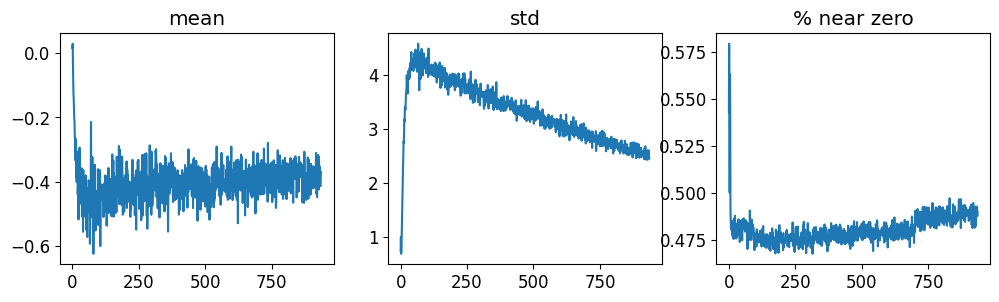

In [47]:
# not good results -- figure out why
  # models should have consistent / smooth mean and std
  # here, adctivations near 0 are horrible
  # also, activations near 0 are not good. Means a computation is doing nothing
learn.activation_stats.plot_layer_stats(0)

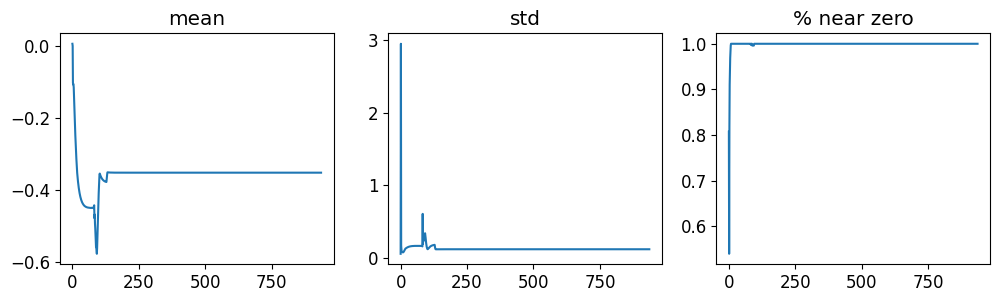

In [48]:
# check second to last layer of the network
  # problems are even worse now -- instability and 0 activations have compounded
learn.activation_stats.plot_layer_stats(-2)

## Making training stable
Try increasing batch size

epoch,train_loss,valid_loss,accuracy,time
0,2.305255,2.301814,0.113500,01:36


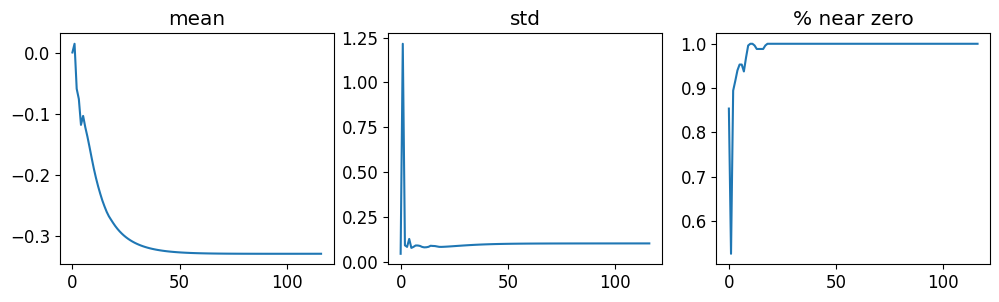

In [49]:
# increased batch size doesn't help much with problems (but accuracy is better)
mnist_dls = get_mnist_dls(512)
learn = fit()
learn.activation_stats.plot_layer_stats(-2)

### 1-cycle training
  - Change learning rate during from training, from low to high to low again
  - Warmup = learning rate from min to max
  -A nnealing = learning rate from max to min
  - 1-cycle training = warmup + annealing

In [50]:
# fit with 1-cycle training
  # note: other params with fit_one_cycle: lrmax, div, div_final, pct_start, moms
def fit(epochs=1, lr=0.06):
  learn = Learner(
    mnist_dls,
    simple_cnn(),
    loss_func=F.cross_entropy,
    metrics=accuracy,
    cbs=ActivationStats(with_hist=True)
  )
  learn.fit_one_cycle(epochs, lr) # this adds the 1-cycle training
  return learn

In [51]:
# fit -- much better
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.197353,0.067397,0.979800,01:27


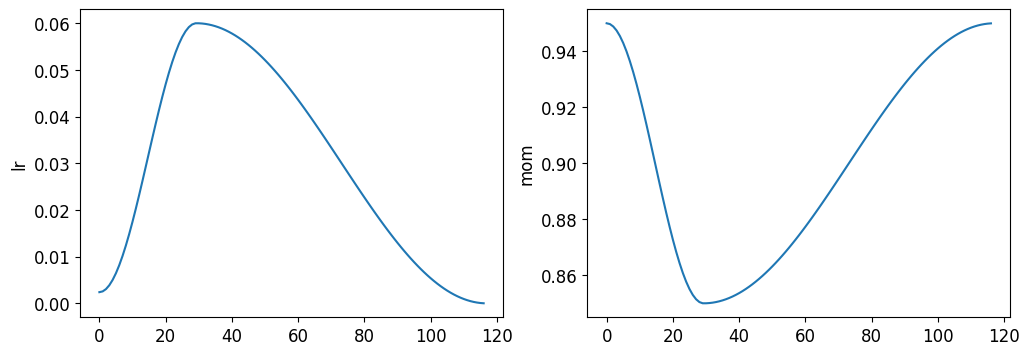

In [52]:
# see the learning rate and momentum
learn.recorder.plot_sched()

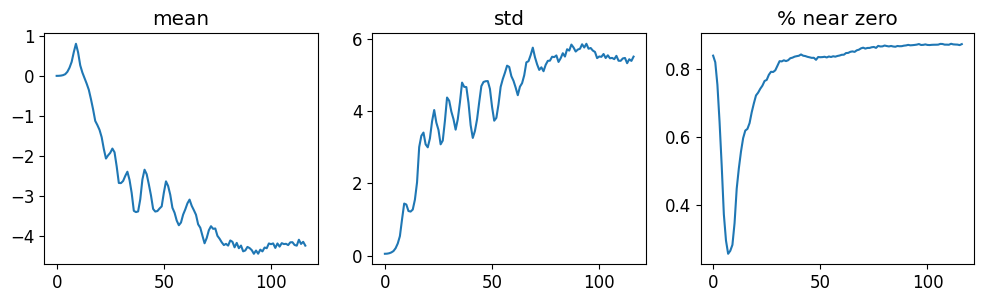

In [53]:
# penultimate layer stats -- getting better
learn.activation_stats.plot_layer_stats(-2)

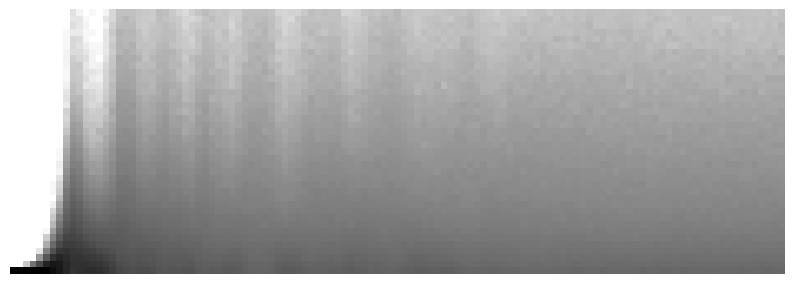

In [54]:
# create a histogram of the activations of a layer
  # shows "brad training": nearly all activations are at 0 at the beginning (white on the left)
  # then gets better (gray), then gets worse again (white), then gets more stable (gray)
learn.activation_stats.color_dim(-2)

### Batch Normalization
  - Helps fix the initial large percentage of near-0 activations (and keep a good distribution of activations throughout training)
  - Takes an average of the mean and std devs of the activations of a layer and uses those to normalize the activations
  - gamma and beta are learnable params that are updated throughout SGD
  - Allows activations to have any mean or variable (independent form the mean / std dev from the results of the previous layer)
  - Training: use the mean / std dev of the batch to normalize the data
  - Validation: use running mean of the statistics calculated during training
  - Tends to result in models that generalize better than models without batch normlization (each mini-batch is normalized by different values each time, leading to some random elements)

In [55]:
# add batchnorm to conv
def conv(ni, nf, ks=3, act=True):
  layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
  if act: layers.append(nn.ReLU())
  layers.append(nn.BatchNorm2d(nf)) # batchnorm
  return nn.Sequential(*layers)

In [56]:
# fit
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.132637,0.053573,0.987000,01:28


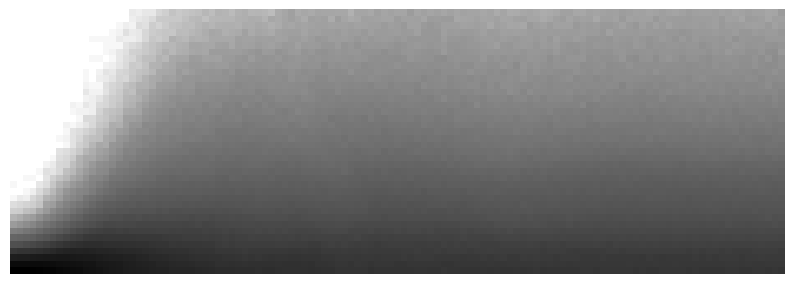

In [57]:
# examine color dims again
  # much better -- smooth development of activations (no "crashes")
learn.activation_stats.color_dim(-4)

In [58]:
# try again, with higher learning rate!
# very good!
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.182792,0.143846,0.956400,01:29
1,0.080205,0.046808,0.984200,01:28
2,0.049671,0.045419,0.986700,01:27
3,0.031809,0.028394,0.990800,01:28
4,0.015976,0.025484,0.992500,01:36
